In [1]:
# helper code from the course repository
!git clone https://github.com/interactiveaudiolab/course-deep-learning.git
# install common pacakges used for deep learning
!cd course-deep-learning/ && pip install -r requirements.txt

Cloning into 'course-deep-learning'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 575 (delta 15), reused 19 (delta 8), pack-reused 547 (from 1)
Receiving objects: 100% (575/575), 146.09 MiB | 24.61 MiB/s, done.
Resolving deltas: 100% (303/303), done.
Updating files: 100% (63/63), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/

In [2]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
# %cd course-deep-learning/

In [7]:
# Data Augumentation
class LinearNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(28*28, 1024)
        self.layer_2 = nn.Linear(1024, 10)
        self.relu = nn.ReLU()
    def forward(self, x):
        batch_size, channels, heights, widths = x.size()

        x = x.view(batch_size, -1)
        x = self.relu(self.layer_1(x))
        x = self.layer_2(x)
        return x

class ConvNetwork(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(1,32,3,1) # (batch_size, channel, height, width)
      self.conv2 = nn.Conv2d(32, 64, 3,1)
      self.relu = nn.ReLU()

      self.dropout1 = nn.Dropout(0.25)
      self.dropout2 = nn.Dropout(0.5)
      self.pool = nn.MaxPool2d(4) # because we use cnn is 2-dimensional
      # use the fully-connected network to map our learned convolutional
      # features to class predictions
      self.fc1 = nn.Linear(64*6*6, 128)
      self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
      # inputs are expected to have shape (batch_size, 1, 28, 28)
      x = self.conv1(x)
      x = self.relu(x)

      # output 2-d, first convolutional layer reshapes inputs to (batch_size, 32, 64, 64)

      x = self.conv2(x)
      x = self.relu(x)

      x = self.pool(x) # use pool method to reduce the spatial dimensions of the feature maps,
# our pooling layer reduces inputs to (batch_size, 64, 6, 6)
      x = self.dropout1(x)
# we "flatten" inputs to (batch_size, 64*6*6) before passing a small fully-connected network
# before: (batch_size, 64, 6, 6) now: (batch_size, 64*6*6)
      x = torch.flatten(x, 1)
      x = self.fc1(x)
      x = self.relu(x)
      x = self.dropout2(x)
      x = self.fc2(x)

      return x
def param_count(m: nn.Module):
      # assess the complexity
      # count the number of trainable parameters (weights) in a model
    return sum([p.shape.numel() for p in m.parameters() if p.requires_grad])

model1 = LinearNetwork()
model2 = ConvNetwork()

params1 = param_count(model1)
params2 = param_count(model2)

print(f"Parameters in fully-connected network: {params1}")
print(f"Parameters in fully-connected network: {params2}")
print(f"The convoluntional network has {params2/params1 :0.2f}x as many parameters")



Parameters in fully-connected network: 814090
Parameters in fully-connected network: 315146
The convoluntional network has 0.39x as many parameters


In [8]:
def training_loop(save_path, epochs, batch_size, device="cpu", use_conv=False):
    """
    Train a neural network model for digit recognition on the MNIST dataset.

    Parameters
    ----------
    save_path (str):  path/filename for model checkpoint, e.g. 'my_model.pt'

    epochs (int):     number of iterations through the whole dataset for training

    batch_size (int): size of a single batch of inputs

    device (str):     device on which tensors are placed; should be 'cpu' or 'cuda'.

    use_conv (bool):  if True, use ConvNetwork; else, use LinearNetwork.

    Returns
    -------
    model (nn.Module): final trained model

    save_path (str):   path/filename for model checkpoint, so that we can load our model
                       later to test on unseen data

    device (str):      the device on which we carried out training, so we can match it
                       when we test the final model on unseen data later
    """

    # initialize model
    if use_conv:
      model = ConvNetwork()
      print('Training convolutional neural network...')
    else:
      model = LinearNetwork()
      print('Training fully-connected neural network...')

    print(f'Parameters in model: {param_count(model)}')
    model.to(device)

    # initialize an optimizer to update our model's parameters during training
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0)

    # make a new directory in which to download the MNIST dataset
    data_dir = "./data/"

    # initialize a Transform object to prepare our data
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        lambda x: x>0,
        lambda x: x.float(),
    ])

    # load MNIST "test" dataset from disk
    mnist_test = datasets.MNIST(data_dir, train=False, download=True, transform=transform)

    # load MNIST "train" dataset from disk and set aside a portion for validation
    mnist_train_full = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train_full, [55000, 5000])

    # initialize a DataLoader object for each dataset
    train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
    test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=False)

    # a PyTorch categorical cross-entropy loss object
    loss_fn = torch.nn.CrossEntropyLoss()

    # time training process
    st = time.time()

    # keep track of best validation accuracy; if improved upon, save checkpoint
    best_acc = 0.0

    # time to start training!
    for epoch_idx, epoch in enumerate(range(epochs)):

        # loop through the entire dataset once per epoch
        train_loss = 0.0
        train_acc = 0.0
        train_total = 0
        model.train()
        for batch_idx, batch in enumerate(train_dataloader):

            # clear gradients
            optimizer.zero_grad()

            # unpack data and labels
            x, y = batch
            x = x.to(device)  # we'll cover this in the next section!
            y = y.to(device)  # we'll cover this in the next section!

            # generate predictions and compute loss
            output = model(x)  # (batch_size, 10)
            loss = loss_fn(output, y)

            # compute accuracy
            preds = output.argmax(dim=1)
            acc = preds.eq(y).sum().item()/len(y)

            # compute gradients and update model parameters
            loss.backward()
            optimizer.step()

            # update statistics
            train_loss += (loss * len(x))
            train_acc += (acc * len(x))
            train_total += len(x)

        train_loss /= train_total
        train_acc /= train_total

        # perform validation once per epoch
        val_loss = 0.0
        val_acc = 0.0
        val_total = 0
        model.eval()
        for batch_idx, batch in enumerate(val_dataloader):

            # don't compute gradients during validation
            with torch.no_grad():

                # unpack data and labels
                x, y = batch
                x = x.to(device)  # we'll cover this in the next section!
                y = y.to(device)  # we'll cover this in the next section!

                # generate predictions and compute loss
                output = model(x)
                loss = loss_fn(output, y)

                # compute accuracy
                preds = output.argmax(dim=1)
                acc = preds.eq(y).sum().item()/len(y)

                # update statistics
                val_loss += (loss * len(x))
                val_acc += (acc * len(x))
                val_total += len(x)

        val_loss /= val_total
        val_acc /= val_total
        print(f"Epoch {epoch_idx + 1}: val loss {val_loss :0.3f}, val acc {val_acc :0.3f}, train loss {train_loss :0.3f}, train acc {train_acc :0.3f}")

        if val_acc > best_acc:
            print(f"New best accuracy {val_acc : 0.3f} (old {best_acc : 0.3f}); saving model weights to {save_path}")
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)

    print(f"Total training time (s): {time.time() - st :0.3f}")

    return model, save_path, device


Data Augmentation:
There are many ways to squeeze some extra performance. One way is to use the data augmentation method:

1) If dataset is small, we can use data augmentation method to augmentate it.

2) Robust against real-world transformation. Invariant when validating on different models.


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 34.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.92MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 12.3MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.05MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



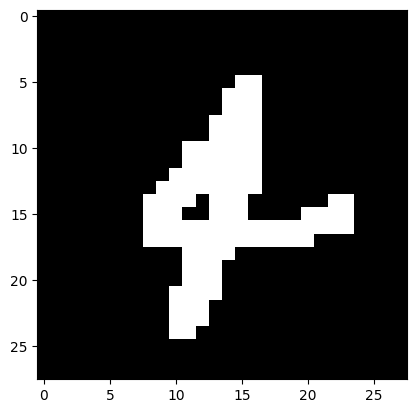

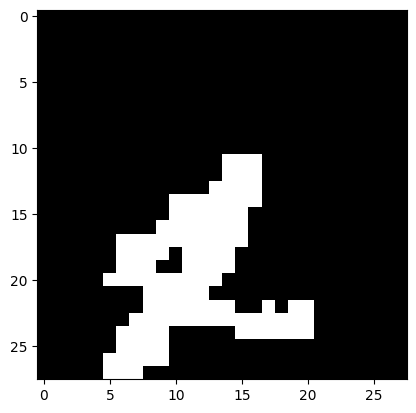

In [10]:
# We can use Transform in torchvision to solve this problem
data_dir = "./data/"

# initialize a Transform object to prepare our data
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    lambda x: x>0,
    lambda x: x.float(),
])

# load MNIST "train" dataset from disk
mnist_train = datasets.MNIST(data_dir, train=False, download=True, transform=transform)

# fetch an image from the MNIST dataset
example_img, example_label = mnist_train[300]
plt.imshow(example_img.squeeze(), cmap='gray')
plt.show()

# perform a random affine transformation of an input (rotation, translation, shear)

affine_aug = torchvision.transforms.RandomAffine(degrees=(-30, 30), translate=(0.25, 0.25), shear=(-45, 45))
augmented = affine_aug(example_img)
plt.imshow(augmented.squeeze(), cmap='gray')
plt.show()